# Preprocessing Data

We will be using the [Rotten Tomatoes movie reviews dataset](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data).

In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile
import os

api = KaggleApi()
api.authenticate()

for file in ['train.tsv', 'test.tsv']:
    api.competition_download_file('sentiment-analysis-on-movie-reviews', f'{file}.zip', path='./')

    with zipfile.ZipFile(f'{file}.zip', 'r') as zip_ref:
        zip_ref.extractall('./')

    os.remove(f'{file}.zip')

100%|█████████████████████████████████████████████████████████████████████████████| 1.28M/1.28M [00:00<00:00, 6.49MB/s]


100%|███████████████████████████████████████████████████████████████████████████████| 494k/494k [00:00<00:00, 4.53MB/s]

---

## Preparing Data

We will start by reading the data into a Pandas Dataframe using th `read_csv` function. Because we're working with *.tsv* (*tab seperate values*) files we need to specify that we will be taking tab characters as the delimiters:

In [2]:
import pandas as pd

df = pd.read_csv('train.tsv', sep='\t')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


The *Phrase* column contains all of our text data that we will be processing. We can also see that there are many copies through *segments* of the same answer (note that the *SentenceId* value for each of these copies is identical). We can reduce the amount of noise in our dataset by removing these duplicates.

In [3]:
#df = df.drop_duplicates(subset=['SentenceId'], keep='first')

df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


Let's check the distribution of sentiment classes across our data.

<AxesSubplot:>

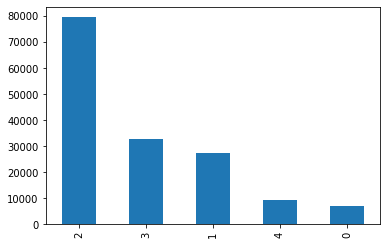

In [4]:
df['Sentiment'].value_counts().plot(kind='bar')

We will be tokenizing this text to create two input tensors; our input IDs, and attention mask.

We will contain our tensors within two numpy arrays, which will be of dimensions `len(df) * 512` - the `512` is the sequence length of our tokenized sequences for BERT, and `len(df)` the number of samples in our dataset.

In [5]:
import numpy as np

seq_len = 512
num_samples = len(df)

num_samples, seq_len

(156060, 512)

Now we can begin tokenizing with a `BertTokenizer`, like so:

In [6]:
from transformers import BertTokenizer

# initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# tokenize - this time returning Numpy tensors
tokens = tokenizer(df['Phrase'].tolist(), max_length=seq_len, truncation=True,
                   padding='max_length', add_special_tokens=True,
                   return_tensors='np')

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Which returns us three numpy arrays - *input_ids*, *token_type_ids*, and *attention_mask*.

In [7]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [8]:
tokens['input_ids'][:10]

array([[  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       ...,
       [  101, 13936, 25265, ...,     0,     0,     0],
       [  101, 13936, 25265, ...,     0,     0,     0],
       [  101, 15107,  1103, ...,     0,     0,     0]])

In [9]:
tokens['attention_mask'][:10]

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

And now we save them to file as Numpy binary files:

In [10]:
with open('movie-xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])
with open('movie-xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

Now that we have them on file, we can delete the in-memory arrays to free up memory.

In [11]:
del tokens

Our input tensors are prepared, but we haven't touched our target data yet. So, let's move onto that.

Presently our target data is a set of integer values (representing sentiment classes) in the *Sentiment* column of our dataframe `df`. We need to extract these values and *one-hot* encode them into another numpy array, which will have the dimensions `len(df) * number of label classes`. Again, we will initialize a numpy zero array beforehand, but we won't populate it row by row - we will use some fancy indexing techniques instead.

In [12]:
# first extract sentiment column
arr = df['Sentiment'].values

In [13]:
# we then initialize the zero array
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(156060, 5)

We are able to use `arr.max()+1` to define our second dimension here because we have the values *\[0, 1, 2, 3, 4\]* in our *Sentiment* column, there are **five** unique labels which means we need our labels array to have five columns (one for each) - `arr.max() = 4`, so we do `4 + 1` to get our required value of `5`.

Now we use the current values in our `arr` of *\[0, 1, 2, 3, 4\]* to place `1` values in the correct positions of our presently zeros-only array:

In [14]:
labels[np.arange(num_samples), arr] = 1

labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

And there is our one-hot encoded labels array. Just like before, we save this to file as a Numpy binary file.

In [15]:
with open('movie-labels.npy', 'wb') as f:
    np.save(f, labels)